In [2]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
Rshape = (17, 40, 38)
Lshape = (20, 42, 38)

In [16]:
def create_frite(arr, position, length, main_dim):
    """Adds a frite with a given length along the given axis at given position in an array.

    Arguments:
        - arr: array to put the frite in
        - position: coords of the middle of the frite
        - length: length of the frite
        - main_dim: 0,1 or 2. Dimension the longest side is along"""

    width = 3
    dims_frite = []

    for i in range(3):
        if i == main_dim:
            dim_min = int(position[i] - length/2)
            dim_max = int(position[i] + length/2)
        else:
            dim_min = int(position[i] - width/2)
            dim_max = int(position[i] + width/2)
        dims_frite.append([dim_min, dim_max])
    
    arr[dims_frite[0][0]:dims_frite[0][1],
        dims_frite[1][0]:dims_frite[1][1],
        dims_frite[2][0]:dims_frite[2][1]] = 60

    return arr

[ 0. 60.]


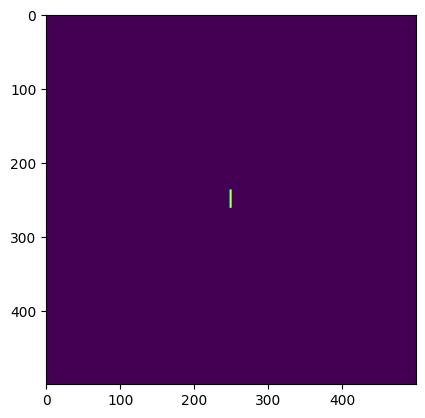

In [17]:
# test of create_frite

arr = np.zeros((500,500,500))
arr = create_frite(arr, (250,250,250), 25, 0)

print(np.unique(arr))

plt.imshow(arr[:,250,:])

In [20]:
def get_boundaries(size, alpha):
    bound_min = int(size//2 * (1 - alpha))
    bound_max = int(size//2 * (1 + alpha))
    
    if (bound_min < 0) or (bound_max > size):
        raise ValueError("Choose a smaller alpha")
    
    return bound_min, bound_max

In [29]:
def generate_pos(shape, alpha, orient, double=False):
    xmin, xmax = get_boundaries(shape[0], alpha)
    ymin, ymax = get_boundaries(shape[1], alpha)
    zmin, zmax = get_boundaries(shape[2], alpha)

    x = rd.randint(xmin, xmax)
    y = rd.randint(ymin, ymax)
    z = rd.randint(zmin, zmax)

    if double:
        x2 = x
        y2 = y
        z2 = z

        dim_to_change = rd.randint(0,3)
        while dim_to_change == orient:
            dim_to_change = rd.randint(1,3)
        
        if dim_to_change == 0:
            x2 = rd.choice([x2+5, x2-5])
        elif dim_to_change == 1:
            y2 = rd.choice([y2+5, y2-5])
        else:
            z2 = rd.choice([z2+5, z2-5])

        return (x, y, z), (x2, y2, z2)

    return (x, y, z)

pos, pos2 = generate_pos(Rshape, 0.2, 1, double=True)

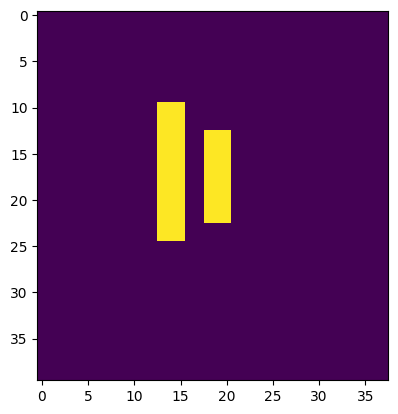

In [37]:
def apply_frites(shape, length, orient, pos, pos2=None):
    arr = np.zeros(shape)
    arr = create_frite(arr, pos, length, orient)
    if pos2:
        arr = create_frite(arr, pos2, int(2/3 * length), orient)
    
    return arr

arr = apply_frites(Rshape, 15, 1, pos, pos2=pos2)

plt.imshow(arr[6,:,:])

In [44]:
# generate the np arrays

N_subjects = 2500
alpha = 0.1
length_frite = 15
Rshape = (17, 40, 38)
Lshape = (20, 42, 38)

R_arrays = []
L_arrays = []
Right_PCS = []
Left_PCS = []
PCS_asymetry = []

for i_sub in range(N_subjects):
    orient = rd.randint(1,3)

    # right side
    R_double = bool(rd.randint(0,2))
    pos, pos2 = generate_pos(Rshape, alpha, orient, double=True)

    if R_double:
        arr = apply_frites(Rshape, length_frite, orient, pos, pos2=pos2)
    else:
        arr = apply_frites(Rshape, length_frite, orient, pos, pos2=None)
    R_arrays.append(arr)

    # left side
    L_double = bool(rd.randint(0,2))
    pos, pos2 = generate_pos(Lshape, alpha, orient, double=True)

    if L_double:
        arr = apply_frites(Lshape, length_frite, orient, pos, pos2=pos2)
    else:
        arr = apply_frites(Lshape, length_frite, orient, pos, pos2=None)
    L_arrays.append(arr)

    # treat labels
    Right_PCS.append(R_double)
    Left_PCS.append(L_double)
    PCS_asymetry.append(R_double != L_double)

R_arrays = np.array(R_arrays)
L_arrays = np.array(L_arrays)
Right_PCS = np.array(Right_PCS, dtype=int)
Left_PCS = np.array(Left_PCS, dtype=int)
PCS_asymetry = np.array(PCS_asymetry, dtype=int)

# check if good label repartition
print(PCS_asymetry.sum(), len(PCS_asymetry))

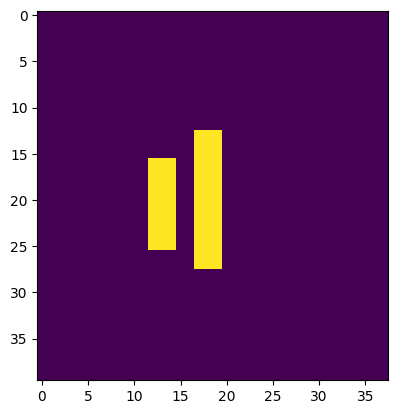

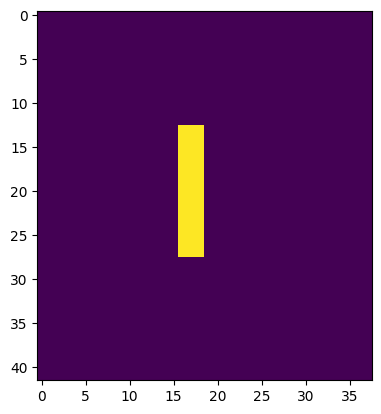

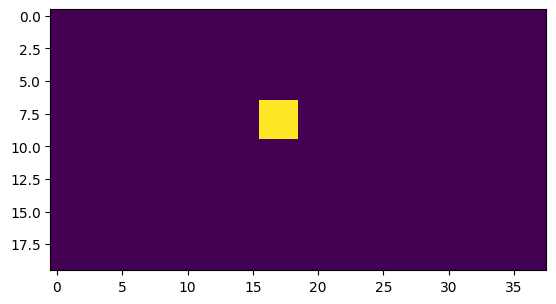

1 0 1


In [46]:
i_test = 51

plt.imshow(R_arrays[i_test][7])
plt.figure()
plt.imshow(L_arrays[i_test][7])
plt.figure()
plt.imshow(L_arrays[i_test][:,20,:])
plt.show()
print(Right_PCS[i_test], Left_PCS[i_test], PCS_asymetry[i_test])

In [48]:
# save the arrays

save_path = "/neurospin/dico/data/deep_folding/current/datasets/benchmarks/frites"

# add the required extra dim
R_arrays = np.expand_dims(R_arrays, -1)
L_arrays = np.expand_dims(L_arrays, -1)

print(R_arrays.shape, L_arrays.shape)

np.save(save_path+'/Rarrays.npy', R_arrays)
np.save(save_path+'/Larrays.npy', L_arrays)

(2500, 17, 40, 38, 1) (2500, 20, 42, 38, 1)


In [49]:
# save the labels

names = ['fake_'+str(i) for i in range(N_subjects)]
liste_labels = [names, Right_PCS, Left_PCS, PCS_asymetry]
labels_df = pd.DataFrame(np.transpose(liste_labels), columns=['Sub_ID', 'Right_PCS', 'Left_PCS', 'PCS_asymetry'])
labels_df.to_csv(save_path+'/labels.csv')

In [50]:
# save the subjects + generate train_val

subjects = labels_df['Sub_ID']
subjects = subjects.rename('Subject')

subjects.to_csv(save_path+'/subjects.csv')

train_val_percentage = 0.8

train_val, test = train_test_split(subjects, train_size=train_val_percentage)

print(train_val)
print(test)

train_val.to_csv(save_path+'/train_val_subjects.csv', index=False, header=False)

1054    fake_1054
2014    fake_2014
1404    fake_1404
630      fake_630
1524    fake_1524
          ...    
2252    fake_2252
1981    fake_1981
143      fake_143
2184    fake_2184
233      fake_233
Name: Subject, Length: 2000, dtype: object
550      fake_550
2316    fake_2316
635      fake_635
618      fake_618
546      fake_546
          ...    
1728    fake_1728
121      fake_121
120      fake_120
777      fake_777
669      fake_669
Name: Subject, Length: 500, dtype: object
